In [2]:
import csv
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sksurv.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

from torchtuples.callbacks import EarlyStopping
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import brier_score_loss
from lifelines.utils import concordance_index
from sklearn.metrics import log_loss

import torch
import torch.nn as nn
import torchtuples as tt

import shap
from shap import KernelExplainer

In [3]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

In [4]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

In [5]:
# select feature to take dummy 
dummy_f = ['REGION','MARST', 'RACEA', 'USBORN', 'HSTATYR', 'ALCSTAT1', 'SMOKESTATUS2']

# conver to int for more compact dummy featues names
df_train[dummy_f] = df_train[dummy_f].astype(int)
df_test[dummy_f] = df_test[dummy_f].astype(int)
df_val[dummy_f] = df_val[dummy_f].astype(int)

# get dummy
df_train = pd.get_dummies(df_train, columns=dummy_f, prefix=dummy_f).astype(int)
df_val = pd.get_dummies(df_val, columns=dummy_f, prefix=dummy_f).astype(int)
df_test = pd.get_dummies(df_test, columns=dummy_f, prefix=dummy_f).astype(int)

In [6]:
# list of columns to standardize
cols_stand = ['AGE', 'BMICALC', 'HRSLEEP']
# list of columns to normalize
cols_norm = ['FAMSIZE', 'EDUCREC1', 'POVERTY', 'FSRAWSCORE', 'ALC5UPYR', 'ALCAMT', 'ALCDAYSYR',
              'CIGSDAY', 'MOD10DMIN', 'MOD10FWK', 'VIG10DMIN', 'VIG10FWK', 'STRONGFWK', 'AEFFORT', 
              'AFEELINT1MO', 'AWORTHLESS', 'WRYMEDCST', 'WRYRET',
              'SEX', 'HINOTCOVE', 'HIPRIVATEE', 'HIMCAIDE', 'HIMCAREE', 'ARTHGLUPEV',
              'BLIND', 'CANCEREV', 'CHEARTDIEV', 'CPOXEV', 'DIABETICEV', 'EMPHYSEMEV',
              'HEARTATTEV', 'HEARTCONEV', 'HYPERTENEV', 'KIDNEYWKYR', 'LIVERCHRON',
              'LIVERCONYR', 'STROKEV']

# list of columns not to standardize
cols_leave = [col for col in df_train.columns if col not in cols_stand + cols_norm + ['TIMETOEVENT', 'MORTSTAT']]

# create mapper entries
standardize = [([col], StandardScaler()) for col in cols_stand]
normalize = [([col], MinMaxScaler()) for col in cols_norm]
leave = [(col, None) for col in cols_leave]

# combine into one mapper
x_mapper = DataFrameMapper(standardize + normalize + leave, df_out=False)

# prepare X matrices
x_train = df_train.drop(columns=['MORTSTAT', 'TIMETOEVENT'])
x_val = df_val.drop(columns=['MORTSTAT', 'TIMETOEVENT'])
x_test = df_test.drop(columns=['MORTSTAT', 'TIMETOEVENT'])

# transform
x_train = x_mapper.fit_transform(x_train).astype('float32')
x_val = x_mapper.transform(x_val).astype('float32')
x_test = x_mapper.transform(x_test).astype('float32')

In [7]:
# get the transformed column names by matching them to the original columns
transformed_column_names = cols_stand + cols_norm + cols_leave
x_train_df_transformed = pd.DataFrame(x_train, columns=transformed_column_names)

feature_names= list(x_train_df_transformed.columns)

In [8]:
# Transform with DataFrameMapper and convert to PyTorch tensors
x_train = torch.tensor(x_mapper.fit_transform(df_train.drop(columns=['MORTSTAT', 'TIMETOEVENT'])), dtype=torch.float32)

x_val = torch.tensor(x_mapper.transform(df_val.drop(columns=['MORTSTAT', 'TIMETOEVENT'])), dtype=torch.float32)

x_test = torch.tensor(x_mapper.transform(df_test.drop(columns=['MORTSTAT', 'TIMETOEVENT'])), dtype=torch.float32)

In [9]:
# define three-year mortality status as PyTorch tensors
y_train = torch.tensor(np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 1, 0), dtype=torch.float32).view(-1, 1)

y_val = torch.tensor(np.where((df_val["MORTSTAT"] == 1) & (df_val["TIMETOEVENT"] <= 3), 1, 0), dtype=torch.float32).view(-1, 1)

y_test = torch.tensor(np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 1, 0), dtype=torch.float32).view(-1, 1)

In [10]:
# train model

In [11]:
# set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)


# define the network
in_features = x_train.shape[1]
net = tt.practical.MLPVanilla(in_features, [16], 1, activation=nn.ReLU, dropout=0.2)


# model and optimizer
loss_fn = nn.BCEWithLogitsLoss()
model = tt.Model(net, loss_fn, tt.optim.Adam)  
model.optimizer.set_lr(0.001)  


# training setup      
batch_size = 800
epochs = 40
checkpoint_path = 'best_model.pt'
# early stopping
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
callbacks = [EarlyStopping(patience=20, file_path=checkpoint_path)]


# fit
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, val_data=(x_test, y_test), 
                shuffle=True, callbacks=callbacks, verbose=True)

0:	[0s / 0s],		train_loss: 0.6416,	val_loss: 0.5813
1:	[0s / 0s],		train_loss: 0.5017,	val_loss: 0.3955
2:	[0s / 0s],		train_loss: 0.3187,	val_loss: 0.2256
3:	[0s / 0s],		train_loss: 0.2034,	val_loss: 0.1524
4:	[0s / 0s],		train_loss: 0.1554,	val_loss: 0.1277
5:	[0s / 0s],		train_loss: 0.1371,	val_loss: 0.1184
6:	[0s / 1s],		train_loss: 0.1300,	val_loss: 0.1144
7:	[0s / 1s],		train_loss: 0.1252,	val_loss: 0.1119
8:	[0s / 1s],		train_loss: 0.1225,	val_loss: 0.1106
9:	[0s / 1s],		train_loss: 0.1203,	val_loss: 0.1100
10:	[0s / 1s],		train_loss: 0.1191,	val_loss: 0.1095
11:	[0s / 1s],		train_loss: 0.1190,	val_loss: 0.1092
12:	[0s / 2s],		train_loss: 0.1187,	val_loss: 0.1090
13:	[0s / 2s],		train_loss: 0.1171,	val_loss: 0.1087
14:	[0s / 2s],		train_loss: 0.1172,	val_loss: 0.1085
15:	[0s / 2s],		train_loss: 0.1164,	val_loss: 0.1084
16:	[0s / 2s],		train_loss: 0.1166,	val_loss: 0.1084
17:	[0s / 2s],		train_loss: 0.1158,	val_loss: 0.1083
18:	[0s / 2s],		train_loss: 0.1163,	val_loss: 0.1082
19:

In [12]:
# convert to numpy array
x_train_numpy = x_train.cpu().numpy() 
x_test_numpy = x_test.cpu().numpy()  

# set the random seed for reproducibility
np.random.seed(21)

# backgound set 
random_indices_train = np.random.choice(x_train_numpy.shape[0], size=200, replace=False) 
x_train_sampled = x_train_numpy[random_indices_train]  

# data to plot
random_indices_test = np.random.choice(x_test_numpy.shape[0], size=5000, replace=False)  
x_test_subset = x_test_numpy[random_indices_test]

# initialize KernelExplainer 
explainer_kernel = shap.KernelExplainer(model.predict, x_train_sampled)
# compute SHAP values
shap_values_kernel = explainer_kernel.shap_values(x_test_subset)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5000 [00:00<?, ?it/s]

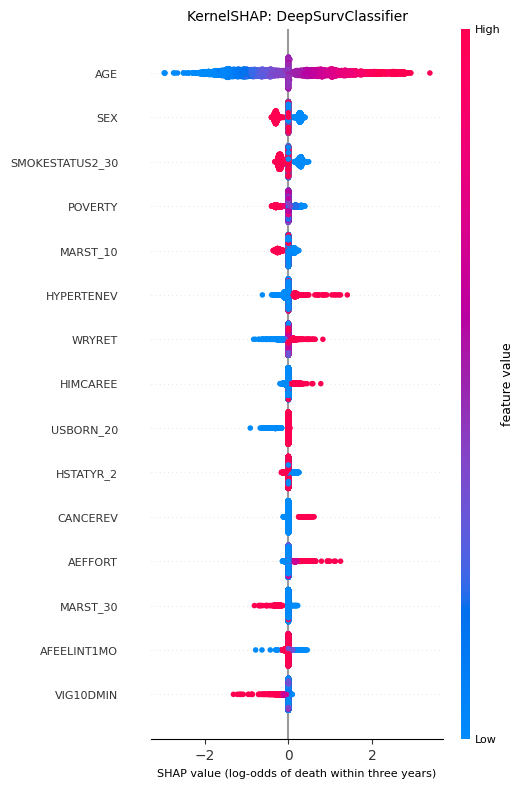

In [13]:
# ---plot---
rng = np.random.default_rng()

# flatten for plotting
shap_values_kernel_flattened = shap_values_kernel.reshape(shap_values_kernel.shape[0], -1)

plt.figure(figsize=(5, 3)) 
shap.summary_plot(shap_values_kernel_flattened, x_test_subset,feature_names=feature_names,  max_display=15, rng=rng, show=False)

plt.xticks(fontsize=10)  
plt.yticks(fontsize=8)  
plt.xlabel("SHAP value (log-odds of death within three years)", fontsize=8)  
plt.title("KernelSHAP: DeepSurvClassifier", fontsize=10) 
fig = plt.gcf()
fig.set_size_inches(5.2, 8) 
cbar = plt.gcf().axes[-1]  
cbar.tick_params(labelsize=8)  
cbar.set_ylabel("feature value", fontsize=9) 
plt.savefig('DeepSurvClassifier_shap.png', format='png', dpi=300, bbox_inches='tight')
plt.show()